# Data preparation and exploratory data analysis

- Input: raw data

- Output: data description and clean data ready for analysis

- Features: This systems takes the provided data and generates a dataframe that can be
used in the machine learning model. Data splitting, description, visualisation, and feature
engineering are important parts your report should include reasons for the choices made
within this system.

# Preparing data

### Modules used

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Trafikkdata

First I read in the data and determine what I can discard. 

In [2]:
trafikkdata_raw = pd.read_csv(('raw_data/trafikkdata.csv'), delimiter=';', low_memory=False)
trafikkdata_raw.head()

,Trafikkregistreringspunkt,Navn,Vegreferanse,Fra,Til,Dato,Fra tidspunkt,Til tidspunkt,Felt,Volum,...,Ikke gyldig lengde,Lengdekvalitetsgrad (%),"< 5,6m",">= 5,6m","5,6m - 7,6m","7,6m - 12,5m","12,5m - 16,0m",">= 16,0m","16,0m - 24,0m",">= 24,0m"
0,17981B2483952,GM.NYG�RDSBRU SYKKEL,FV5332 S1D1 m50,2015-07-16T15:00+02:00,2015-07-16T16:00+02:00,2015-07-16,15:00,16:00,1,-,...,-,-,-,-,-,-,-,-,-,"-,,,,,,,,,,,"
1,17981B2483952,GM.NYG�RDSBRU SYKKEL,FV5332 S1D1 m50,2015-07-16T15:00+02:00,2015-07-16T16:00+02:00,2015-07-16,15:00,16:00,2,-,...,-,-,-,-,-,-,-,-,-,"-,,,,,,,,,,,"
2,17981B2483952,GM.NYG�RDSBRU SYKKEL,FV5332 S1D1 m50,2015-07-16T15:00+02:00,2015-07-16T16:00+02:00,2015-07-16,15:00,16:00,3,-,...,-,-,-,-,-,-,-,-,-,"-,,,,,,,,,,,"
3,17981B2483952,GM.NYG�RDSBRU SYKKEL,FV5332 S1D1 m50,2015-07-16T15:00+02:00,2015-07-16T16:00+02:00,2015-07-16,15:00,16:00,4,-,...,-,-,-,-,-,-,-,-,-,"-,,,,,,,,,,,"
4,17981B2483952,GM.NYG�RDSBRU SYKKEL,FV5332 S1D1 m50,2015-07-16T15:00+02:00,2015-07-16T16:00+02:00,2015-07-16,15:00,16:00,Totalt i retning DANMARKSPLASS,-,...,-,-,-,-,-,-,-,-,-,"-,,,,,,,,,,,"


First 5 columns are irrelevant. Columns 'Trafikkregistreringspunkt', 'Navn' and 'Vegreferanse' will not have any impact on the machine learning model so I will remove those. 

Columns 'Fra' and 'Til' contains information I can get from columns 'Dato' and 'Fra tidspunkt' so I will remove those aswell.

The last 8 columns is blank so I will cut those out.

Columns 'Ikke gyldig lengde' and 'Lengdekvalitetsgrad' deals with vehicle length which is of no use when the goal is to predict volume so I will remove these.

Columns 'Antall timer total' and 'Antall timer inkludert' don't give me anything useful so I will cut those out.

Column 'Antall timer ugyldig' will also be removed as I'm gonna use column 'Dekningsgrad %' to determine what data to use.

In [3]:
td_df = trafikkdata_raw[['Dato', 'Fra tidspunkt', 'Felt', 'Volum', 'Dekningsgrad (%)']] # Make ned dataframe with columns i need

The goal is to predict total volum for each hour so I will select only those rows. The date and time is currently type object so I will change that into datetime format because its easier to work with. I will also combine it into one column. 

The column 'Dekningsgrad %' tells me how accurate and dependable the data is so I will only keep the data that is 100,0% trustworthy to feed the machine learning model.  

In [4]:
td_df = td_df.loc[td_df['Felt'] == 'Totalt'] # Only rows where 'Felt' value is 'Totalt'

td_df = td_df.loc[td_df['Dekningsgrad (%)'].isin(['100,0',',,,,,,,,,,,,'])] # The second argument is to not lose the 2022 data
td_df['Dato'] = pd.to_datetime(td_df['Dato']+td_df['Fra tidspunkt'], format='%Y-%m-%d%H:%M') # Combine and change to datetime
td_df = td_df.rename(columns={'Dato':'Dato + Tid'}) # Better name for date + time column
td_df = td_df.drop(['Fra tidspunkt', 'Felt', 'Dekningsgrad (%)'], axis=1) # Drop unused columns
td_df.head()

,Dato + Tid,Volum
13,2015-07-16 16:00:00,107
20,2015-07-16 17:00:00,84
27,2015-07-16 18:00:00,57
34,2015-07-16 19:00:00,49
41,2015-07-16 20:00:00,45


## Weatherdata

The weather data came in multiple files so first I combine then all into one dataframe.

In [5]:
weather_data_list = ['raw_data/weather_data/Florida_2015.csv',
                    'raw_data/weather_data/Florida_2016.csv',
                    'raw_data/weather_data/Florida_2017.csv',
                    'raw_data/weather_data/Florida_2018.csv',
                    'raw_data/weather_data/Florida_2019.csv',
                    'raw_data/weather_data/Florida_2020.csv',
                    'raw_data/weather_data/Florida_2021.csv',
                    'raw_data/weather_data/Florida_2022.csv']
wd_df = pd.concat(map(pd.read_csv, weather_data_list)) # Combine into one weatherdata dataframe
wd_df.shape

(389422, 9)

The weatherdata comes in 10 minute intervals, while the trafficdata comes in 1 hour intervals. I will therefore change the date and time in weatherdata to a datetime object like i did with trafficdata. Then i can resample it into hourly intervals and combine the two datasets with the common datetime. When resampleing i will take the mean for each column except 'Solskinstid' as i think the sum is a better metrix. 

It was stated in the project description that weatherdata uses code 9999,99 for missing data so i will replace that with NaN for now.

In [6]:
wd_df["Dato"] = pd.to_datetime(wd_df["Dato"]+wd_df["Tid"], format='%Y-%m-%d%H:%M') # Create column with datetime
wd_df = wd_df.drop(['Tid'], axis=1) # drop unused column 'Tid'
wd_df = wd_df.rename(columns={'Dato':'Dato + Tid'}) # better name for the datetime column
wd_df = wd_df.replace(9999.99,np.nan) # replace missing values with NaN for now
wd_df = wd_df.set_index('Dato + Tid') # set datetime as index
wd_df = wd_df.resample('1H').mean() # resample into hourly intervals
wd_df['Solskinstid'] = wd_df['Solskinstid']*6 # scale up to get sum instead of mean
wd_df.head()

,Globalstraling,Solskinstid,Lufttemperatur,Vindretning,Vindstyrke,Lufttrykk,Vindkast
Dato + Tid,,,,,,,
2015-01-01 00:00:00,19.850000,0.0,6.633333,155.000000,3.483333,1008.250000,NaN
2015-01-01 01:00:00,18.916667,0.0,6.816667,153.500000,3.350000,1007.083333,NaN
2015-01-01 02:00:00,21.133333,0.0,6.983333,152.500000,3.783333,1006.016667,NaN
2015-01-01 03:00:00,21.833333,0.0,7.200000,152.666667,4.016667,1005.016667,NaN
2015-01-01 04:00:00,22.883333,0.0,7.533333,154.333333,5.016667,1003.883333,NaN


## Combine into one dataset
Both sets now have datetime in common so it can be combined

In [7]:
td_df = td_df.set_index('Dato + Tid') # Set index to match weather dataset
main_df = td_df.join(wd_df) # Combine the datasets
main_df['Volum'] = pd.to_numeric(main_df['Volum']) # change column Volum's type to float64
main_df.head() # This is what it looks like combined

,Volum,Globalstraling,Solskinstid,Lufttemperatur,Vindretning,Vindstyrke,Lufttrykk,Vindkast
Dato + Tid,,,,,,,,
2015-07-16 16:00:00,107.0,432.833333,48.7,13.733333,317.500000,4.333333,1014.400000,7.20
2015-07-16 17:00:00,84.0,378.400000,60.0,13.866667,318.166667,3.933333,1014.066667,6.55
2015-07-16 18:00:00,57.0,212.583333,60.0,13.216667,319.833333,4.233333,1013.966667,7.15
2015-07-16 19:00:00,49.0,79.750000,60.0,12.683333,323.500000,2.950000,1014.100000,5.45
2015-07-16 20:00:00,45.0,10.633333,36.0,12.066667,333.500000,2.483333,1014.200000,4.25


In [8]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56508 entries, 2015-07-16 16:00:00 to 2022-05-30 20:00:00
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Volum           52911 non-null  float64
 1   Globalstraling  56375 non-null  float64
 2   Solskinstid     56359 non-null  float64
 3   Lufttemperatur  56160 non-null  float64
 4   Vindretning     56165 non-null  float64
 5   Vindstyrke      56161 non-null  float64
 6   Lufttrykk       56161 non-null  float64
 7   Vindkast        56162 non-null  float64
dtypes: float64(8)
memory usage: 3.9 MB


## Data visualization

There are a lot of information in this dataset. To seperate what can be useful and not I will take a look at the correlation between Volum and each column. I will look at correlation up until 2022 as the volum data is missing there. The corr() method ignores null values so I don't have to think about that now.

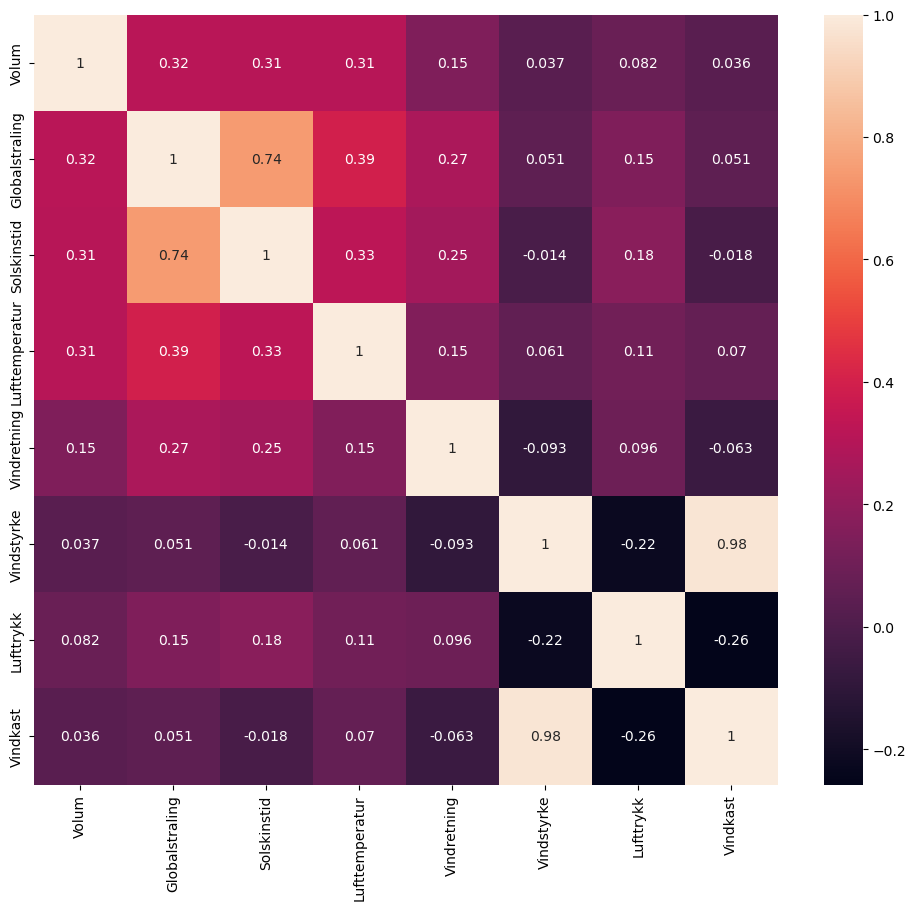

In [9]:
sample = main_df.loc[:'2021'] # Dataframe with all data except for year 2022
plt.figure(figsize=(12,10))
sns.heatmap(sample.corr(), annot=True)
plt.show()

Looking at this tells me in general there is low correlation between the volume and the weather data. Thinking about it logically it makes sense that Vindkast, Lufttrykk, Vindstyrke and Vindretning don't have much affect on Volum. Because of the very low correlation I will not look further into those features. Lufttemperatur, Solskinstid and Globalstraling show some correlation so I will further look into these features. 

In [10]:
main_df = main_df.drop(['Vindretning', 'Vindstyrke', 'Lufttrykk', 'Vindkast'], axis=1) # Drop irrelevant columns

I will look into the year 2020 as its easier to visualize with a smaller dataframe. First I will check if the correlation for 2020 matches the overall. 

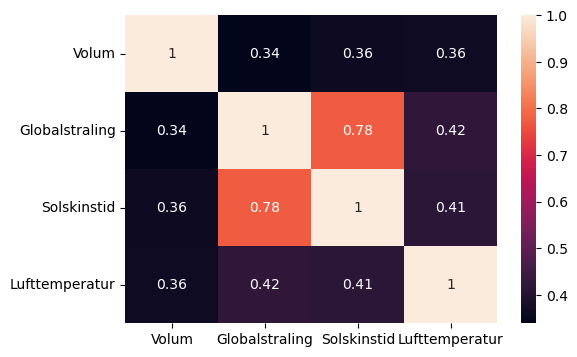

In [11]:
sample2020 = main_df.loc['2020']
plt.figure(figsize=(6,4))
sns.heatmap(sample2020[['Volum', 'Globalstraling', 'Solskinstid', 'Lufttemperatur']].corr(), annot=True)
plt.show()

The correlation is close to equal so its safe to assume what I observe in the subset is also true for the overall dataset.
Further I will reseample the 2020 sample from hourly to daily and split it into three parts as it makes the visualization cleaner. 

The range in Globalstraling is quite high compared to the other features so I have made a seperate graph for that one.

In [12]:
visualize = sample2020.resample('D').mean() # Resample into daily
visualize1 = visualize[0:120] # Split into three parts
visualize2 = visualize[120:240]
visualize3 = visualize[240:365]

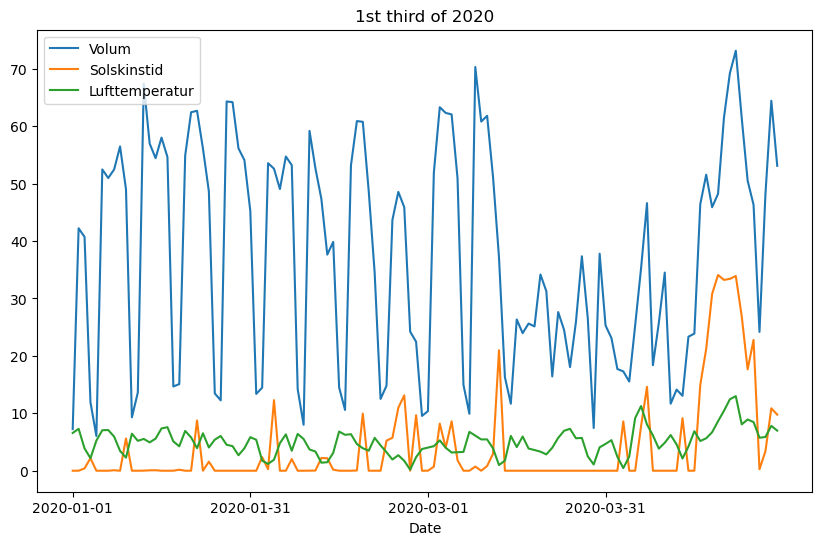

In [13]:
# Visualization of 1st third of 2020
plt.figure(figsize=(10,6))

plt.plot(visualize1.index.values, visualize1['Volum'], label='Volum')
plt.plot(visualize1.index.values, visualize1['Solskinstid'], label='Solskinstid')
plt.plot(visualize1.index.values, visualize1['Lufttemperatur'], label='Lufttemperatur')
#plt.plot(visualize1.index.values, visualize1['Globalstraling'], label='Globalstraling')

plt.title('1st third of 2020')
plt.xticks(visualize1.index.values[::30])
plt.xlabel('Date')

plt.legend()
plt.show()

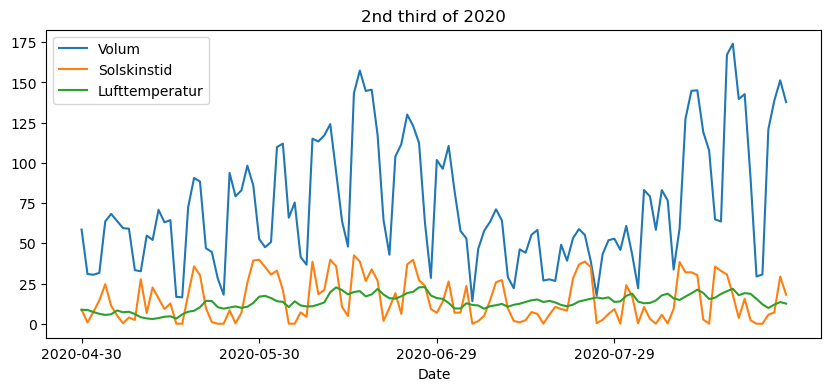

In [14]:
# Visualization of 2nd third of 2020
plt.figure(figsize=(10,4))

plt.plot(visualize2.index.values, visualize2['Volum'], label='Volum')
plt.plot(visualize2.index.values, visualize2['Solskinstid'], label='Solskinstid')
plt.plot(visualize2.index.values, visualize2['Lufttemperatur'], label='Lufttemperatur')
#plt.plot(visualize2.index.values, visualize2['Globalstraling'], label='Globalstraling')

plt.title('2nd third of 2020')
plt.xticks(visualize2.index.values[::30])
plt.xlabel('Date')

plt.legend()
plt.show()

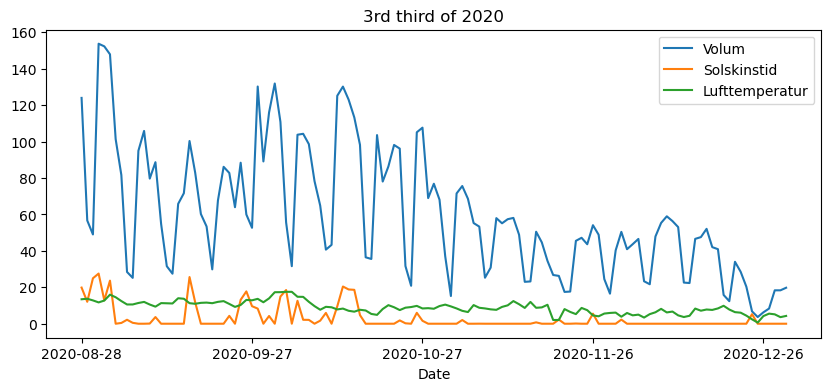

In [15]:
# Visualization of 3rd third of 2020
plt.figure(figsize=(10,4))

plt.plot(visualize3.index.values, visualize3['Volum'], label='Volum')
plt.plot(visualize3.index.values, visualize3['Solskinstid'], label='Solskinstid')
plt.plot(visualize3.index.values, visualize3['Lufttemperatur'], label='Lufttemperatur')
#plt.plot(visualize3.index.values, visualize3['Globalstraling'], label='Globalstraling')

plt.title('3rd third of 2020')
plt.xticks(visualize3.index.values[::30])
plt.xlabel('Date')

plt.legend()
plt.show()

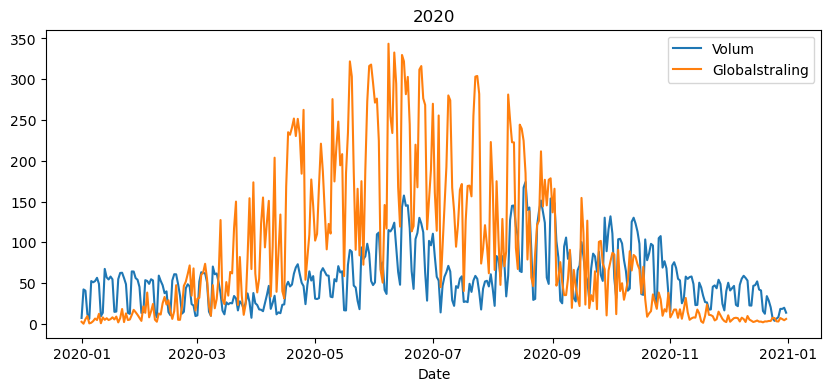

In [16]:
plt.figure(figsize=(10,4))
plt.plot(visualize.index.values, visualize['Volum'], label='Volum')
plt.plot(visualize.index.values, visualize['Globalstraling'], label='Globalstraling')

plt.title('2020')
plt.xlabel('Date')

plt.legend()
plt.show()

These graphs helps to see how the volume correlates to each feature.

Solskinstid: We can see a tendency that when Solskinstid spikes, so does Volum. This is easiest seen in the graph showing the 2nd third of 2020. 

Globalstraling: This feature is similar to Solskinstid. Its values are a bit all over the place but the tendency is the same. Globalstraling and Volum has a tendency to spike at the same time.

Lufttemperatur: This one is not as clear as the other two. Its graph is more linear without any spikes. However, one can see a connection that the warmer it gets, the larger the volume gets. At the start of 2020, when its under 10°C, Volum reaches around 60. While into the 2nd third, when it gets to 20°C and above, Volum reaches up to 170. Likewise, last part of 2020 both Volum and Lufttemperatur steadily decreases.  

## Feature engineering

I believe key features to help determine Volum is hidden in the datetime. I will extract hour, day and month from datetime and check what those features can tell me.

In [17]:
main_df['Hour'] = main_df.index.hour # Extract hour 
main_df['Day'] = main_df.index.dayofweek # Extract day of week (0=Monday,...,6=Sunday)
main_df['Month'] = main_df.index.month # Extract month (1=Januray,...,12=December)

I will compare the hours, days and month by taking the mean of volume for each one. 

Starting with hours.

Hour 0 : 6
Hour 1 : 3
Hour 2 : 2
Hour 3 : 2
Hour 4 : 2
Hour 5 : 6
Hour 6 : 34
Hour 7 : 118
Hour 8 : 145
Hour 9 : 60
Hour 10 : 40
Hour 11 : 41
Hour 12 : 47
Hour 13 : 52
Hour 14 : 74
Hour 15 : 151
Hour 16 : 157
Hour 17 : 92
Hour 18 : 63
Hour 19 : 47
Hour 20 : 37
Hour 21 : 29
Hour 22 : 22
Hour 23 : 13


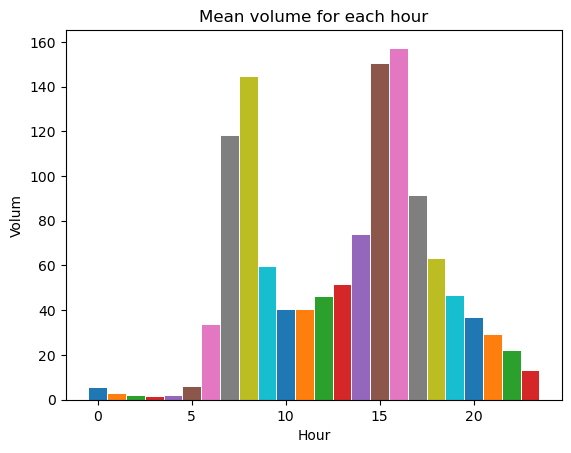

In [18]:
# Comparing hours
fig, ax = plt.subplots()

def checkHour(Hour):
    print('Hour',Hour, ':', round(main_df.loc[main_df['Hour'] == Hour].Volum.mean()))
    
    x = Hour
    y = main_df.loc[main_df['Hour'] == Hour].Volum.mean() # Mean volum for each hour
    ax.bar(x,y,width=1,edgecolor="white",linewidth=0.7) # Visualization 
    
for x in range(24):
    checkHour(x)

plt.title('Mean volume for each hour')
plt.xlabel('Hour')
plt.ylabel('Volum')
plt.show()

This graph makes logical sense. At night, in the hours 0-5, there are few people. The spike at 7 and 8 is likely a rush of people on their way to work. Likewise at 15 and 16 most people are on their way back from work. The vast difference between hours make this feature key to make accurate predictions.

Moving on to days.

Day 0 : 65
Day 1 : 67
Day 2 : 66
Day 3 : 62
Day 4 : 55
Day 5 : 24
Day 6 : 22


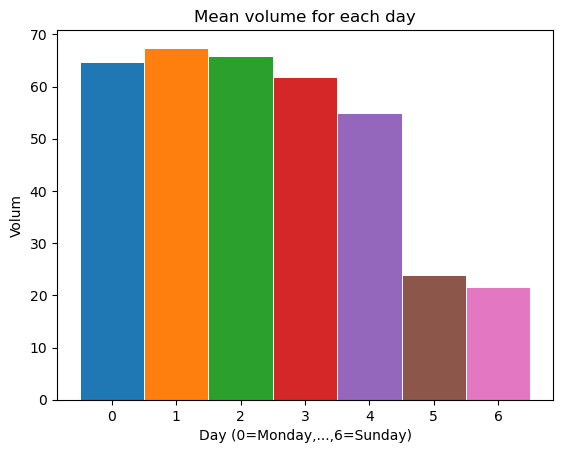

In [19]:
# Comparing days
fig, ax = plt.subplots()

def checkDay(Day):
    print('Day',Day, ':', round(main_df.loc[main_df['Day'] == Day].Volum.mean()))
    
    x = Day
    y = main_df.loc[main_df['Day'] == Day].Volum.mean() # Mean volum for each day
    ax.bar(x,y,width=1,edgecolor="white",linewidth=0.7) # Visualization 
    
for x in range(7):
    checkDay(x)

plt.title('Mean volume for each day')
plt.xlabel('Day (0=Monday,...,6=Sunday)')
plt.ylabel('Volum')
plt.show()

This graph tells me there is not much difference between each day specifically, but rather a significant difference between weekday or weekend day. Where the average volume is close to 3 times higher on a weekday compared to a weekend day. The difference between days are insignificant and therefore excess information. I will change the day column to 1's and 0's where 1 will represent weekdays and 0 weekend days.

In [20]:
main_df['Day'] = main_df['Day'] < 5 # Change Day column to boolean (true = weekday, false = weekend day)
main_df['Day'] = main_df['Day'].astype(int) # Replace true with 1, false with 0
main_df = main_df.rename(columns={'Day':'isWeekday'}) # Rename Day column to isWeekday

Moving on months.

Month 1 : 29
Month 2 : 31
Month 3 : 36
Month 4 : 52
Month 5 : 70
Month 6 : 76
Month 7 : 44
Month 8 : 74
Month 9 : 75
Month 10 : 61
Month 11 : 43
Month 12 : 23


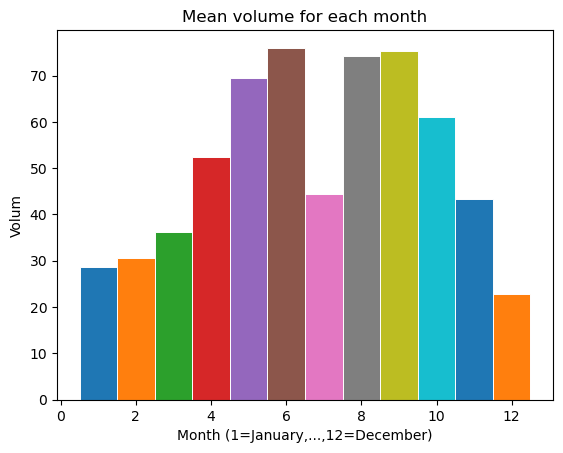

In [21]:
# Comparing months
fig, ax = plt.subplots()

def checkMonth(Month):
    print('Month',Month, ':', round(main_df.loc[main_df['Month'] == Month].Volum.mean()))
    
    x = Month
    y = main_df.loc[main_df['Month'] == Month].Volum.mean() # Mean volum for each month
    ax.bar(x,y,width=1,edgecolor="white",linewidth=0.7) # Visualization 
    
for x in range(1,13):
    checkMonth(x)

plt.title('Mean volume for each month')
plt.xlabel('Month (1=January,...,12=December)')
plt.ylabel('Volum')
plt.show()

As expected based on the analysis of Lufttemperatur earlier, the warmer months have a higher average volume than the colder months. The drop in July (7th month) is likely explained by the fact most people have their summer vacation that month. I believe this feature will be useful when doing predictions.

## Data splitting

I will split the dataset into 70% training, 15% validation and 15% test.

In [22]:
df_2022 = main_df.loc['2022'] # Seperate 2022 data
df_2022.to_csv('clean_data/toPredict_2022.csv') # Save 2022 data in a seperate csv file

df_upUntil_2022 = main_df.loc[:'2021'] # Dataset containing data up until 2022

training_len = int(len(df_upUntil_2022)*0.7) # 70% of dataset
validation_len = int(len(df_upUntil_2022)*0.15) #15% of dataset

training_set = df_upUntil_2022.iloc[:training_len] # First 70%
validation_set = df_upUntil_2022.iloc[training_len:training_len+validation_len] # 15% after the first 70%
test_set = df_upUntil_2022.iloc[training_len+validation_len:] # the last 15%

training_set.to_csv('clean_data/training_set.csv') # Save training_set in a csv file
validation_set.to_csv('clean_data/validation_set.csv') # Save validation_set in a csv file
test_set.to_csv('clean_data/test_set.csv') # Save test_set in a csv file